In [25]:
import numpy as np
import math, random

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from geometry.model import Model, combine_observations, get_mesh
from geometry.utils.visualisation import illustrate_points, illustrate_mesh, illustrate_voxels

from rl.environment import Environment, CombiningObservationsWrapper
from rl.environment import StepPenaltyRewardWrapper, DepthMapWrapper
from rl.dqn import CnnDQN, CnnDQNA


# !conda install -c conda-forge pyembree
# !conda install -c conda-forge igl
# !pip install Cython
# !pip install gym

In [15]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    if len(losses) > 20:
        plt.plot(losses[20:])
    else:
        plt.plot(losses)
    plt.show()

## DQN

In [3]:
USE_CUDA = torch.cuda.is_available()

# if USE_CUDA:
#     torch.cuda.set_device(1)
#     print(torch.cuda.current_device())

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() \
    if USE_CUDA else autograd.Variable(*args, **kwargs)

### Replay buffer

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity, use_gpu=False):
        self.buffer = deque(maxlen=capacity)
        self.use_gpu = use_gpu
    
    def push(self, state, action, reward, next_state, done):
        
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        if self.use_gpu:
            state      = Variable(torch.FloatTensor(np.float32(state)))
            next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
            action     = Variable(torch.FloatTensor([action]))
            reward     = Variable(torch.FloatTensor([reward]))
            done       = Variable(torch.FloatTensor([done]))
        
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        if self.use_gpu:
            state      = torch.cat(state)
            action     = torch.cat(action)
            reward     = torch.cat(reward)
            next_state = torch.cat(next_state)
            done       = torch.cat(done)
        else:
            state      = Variable(torch.FloatTensor(np.float32(np.concatenate(state))))
            next_state = Variable(torch.FloatTensor(np.float32(np.concatenate(next_state))),
                                  volatile=True)
            action     = Variable(torch.FloatTensor(action))
            reward     = Variable(torch.FloatTensor(reward))
            done       = Variable(torch.FloatTensor(done))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)



### Epsilon-greedy

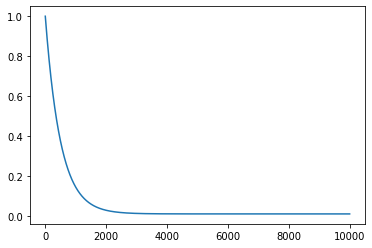

In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * \
        math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(1000)])

In [6]:
def compute_td_loss_actions(batch_size, actions):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

#     state      = Variable(torch.FloatTensor(np.float32(state)))
#     next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
#     action     = Variable(torch.FloatTensor(action))
#     reward     = Variable(torch.FloatTensor(reward))
#     done       = Variable(torch.FloatTensor(done))

    q_value = model(state, action).squeeze(1)
    
    next_q_values = []
    for batch_idx in range(batch_size):
        next_q_value = -np.inf
        for next_action in actions:
            next_action = Variable(torch.FloatTensor([next_action])).unsqueeze(0)
            pred = model(next_state[batch_idx].unsqueeze(0), next_action).item()
            next_q_value = max(next_q_value, pred)
        next_q_values.append(next_q_value)

    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = torch.mean((q_value - expected_q_value) ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [16]:
import gym
from gym import spaces
import k3d

class VoxelGridWrapper(gym.ObservationWrapper):
    def __init__(self, env, grid_shape=(64, 64, 64), illustrate=False):
        super().__init__(env)

        self.grid_shape = grid_shape
        self.illustrate = illustrate
        
        self.observation_space = spaces.Box(0, 1, grid_shape, dtype=bool)

        self.bounds = None
        self.plot = None

    def reset(self):
        observation, action = self.env.reset()
        self.bounds = env.model.mesh.bounds
        
        if self.illustrate:
            self.plot = k3d.plot(name='wrapper')
            self.plot.display()

        return self.observation(observation), action

    def observation(self, observation):
        voxel_grid = np.zeros(self.grid_shape)

        points = observation.points - self.bounds[0]
        indices = points * voxel_grid.shape / (self.bounds[1] - self.bounds[0])
        indices = indices.astype(np.uint32)
        indices = np.unique(indices, axis=0)
        for ind in indices:
            voxel_grid[ind[0], ind[1], ind[2]] = True
        return voxel_grid

    def render(self, action, observation):
        self.plot = illustrate_voxels(observation, self.plot)

    def final_reward(self):
        return self.env.final_reward()



In [17]:
env = Environment(illustrate=False, model_path="./data/Tetrahedron.obj", number_of_view_points=10)
env = CombiningObservationsWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = VoxelGridWrapper(env, illustrate=False)

/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [18]:
from time import sleep

state, _ = env.reset()
for i in range(5):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    env.render(action, state)
    sleep(3)

unable to load materials from: FinalBaseMesh.mtl
specified material (default)  not loaded!


In [19]:
class VoxelDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()

        self.input_shape = input_shape
        # TODO action input
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
            print("Action: ", action)
        else:
            action = random.randrange(env.action_space.n)
            print("Action: ", action, "(random)")
        return action
    
    
    @staticmethod
    def compute_td_loss(batch_size):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        q_values      = model(state)
        next_q_values = model(next_state)

        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + gamma * next_q_value * (1 - done)

        loss = torch.mean((q_value - expected_q_value.detach()) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss



In [20]:
model = VoxelDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()

replay_initial = 100
replay_buffer = ReplayBuffer(200, use_gpu=True)

### Training

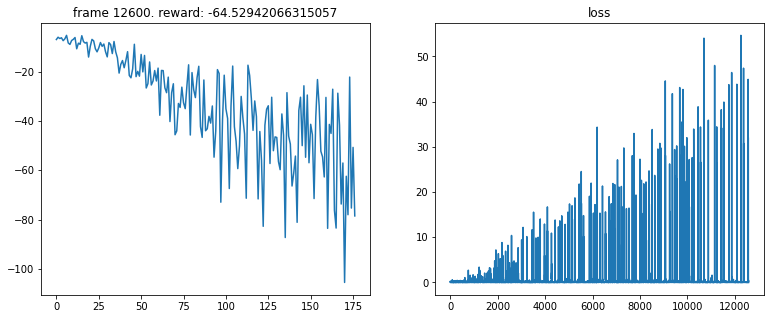

Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  81 (random)
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  94
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  81
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  33
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  17
20
Action:  81
20
Action:  81
20
Action:  81
20
A

KeyboardInterrupt: 

In [26]:
num_frames = 15000
batch_size = 2
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, _ = env.reset()
nof_vp = 0
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    # QUESTION episode_reward += reward * self._gamma ** t

    state = next_state
    episode_reward += reward
    nof_vp += 1

    # env.render(action, state)

    if done:
        # final_reward = env.final_reward()
        # print("Number of View Points: ", nof_vp, " Hausdorff reward: ", final_reward)
        print("Frame: ", frame_idx, "Number of View Points: ", nof_vp)
        print()

        state, _ = env.reset()
        nof_vp = 0
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
#         print("Computing loss")
        loss = model.compute_td_loss(batch_size)
#         print(loss)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 500 ==  0:
        torch.save(model, save_model_path.format(frame_idx))

In [10]:
action.item()

9.0

In [25]:
print((6 * 256 * 256 * 8) / 1e6 * 3000)
print((10 * 512 * 512 * 8) / 1e6 * 5000)

9437.184000000001
104857.6


In [ ]:
TODO Today:
    1. check DQN with A, S as input -> send Sergey
    2. Smaller depth_maps (6 * 256 * 256)
    3. Illustrate reward as area
    4. Distributed Buffer
    
    5. Finish overfit experiments
    
    6. Experiment radius = 1.0
    7. Experiments with smaller reward fine
    8. Experiment with different DQN-s
    9. ABC - write random model reading
    10. * Greedy algo
    11. * Voxels

Ideas:
    1. Add fine for same view_point
    
Big Experiments:
    1. Voxels
    2. PointNet
    3. Context (N first view_points)
    4. Meta-learning, подавать от простой к сложной детальке